In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Viet_AI/Data')
print(os.listdir("."))

['train.csv', 'MLE_at_Epic_Software-SOLUTIONS.ipynb', 'U-net_TF2_retinal_image_segmentation_STARE.ipynb', 'U-net_binary_DB1.ipynb', 'resnet50.h5', 'my_model.h5', 'VietAI.hdf5', 'VietAI_Basline.ipynb', 'test', '.ipynb_checkpoints', 'train', 'logs', 'VietAI_multi-label.ipynb', 'mclass_data.npz', 'CNN_multi.h5', 'data.npz', 'VietAI_Tansfer_learning (1).ipynb', 'TF_30.h5', 'TF_conv_30.h5', 'VietAI_Tansfer_learning-conv.ipynb', 'LP_TF.npz', 'LP_TF_test.npz', 'TF.h5', 'VietAI_Tansfer_learning.ipynb', 'VietAI-visualize.ipynb', 'VietAI_multi_label-multi_class.ipynb', 'Viet_AI_LP_TF_noFalse_all_data.ipynb', 'TF_half_30.h5', 'LP_TF_half.npz', 'LP_TF_half_test.npz', 'VietAI-Label_propagate_TF_data_create.ipynb', 'new_train_data.npz', 'TF_1580_20.h5', 'VietAI-visualize-TF.ipynb', 'output', 'Viet_AI_Results.gsheet', 'ipykernel_launcher.py_plot.png', 'TF_all_20.h5']


In [ ]:
## Importing required Libraries
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, fbeta_score

In [ ]:
#Now load the data
# Load the npy files
npzfile=np.load('LP_TF_half.npz')
print(npzfile.files)
X=np.squeeze(npzfile['arr_0'])
Y=npzfile['arr_1']
UX=np.squeeze(npzfile['arr_2'])
UY=npzfile['arr_3']


['arr_0', 'arr_1', 'arr_2', 'arr_3']


In [ ]:
print(np.shape(X), np.shape(Y))

(2748, 512) (2748,)


In [ ]:
np.unique(Y)

array([  1,   2,   4,   6,   8,  10,  16,  18,  20,  24,  26,  32,  34,
        36,  40,  42,  48,  56,  64,  66,  68,  70,  72,  74,  80,  82,
        84,  90,  96,  98, 100, 104, 106, 120])

In [ ]:
npzfile1=np.load('LP_TF_half_test.npz')
NUX=np.squeeze(npzfile1['arr_0'])
print(np.shape(NUX))

(350, 512)


In [ ]:

#Reduce dimensions of X to 10 to speed up process
pca = PCA(n_components=35)
pca.fit(X)
X1=pca.transform(X)
UX1=pca.transform(UX)
NUX1=pca.transform(NUX)

print(np.shape(X1))

(2748, 35)


In [ ]:
# ! pip uninstall umap
! pip install umap-learn

In [ ]:
import umap.umap_ as umap
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(X)

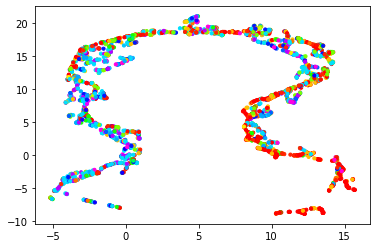

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 10, c=Y, cmap='hsv')

In [ ]:
print(np.shape(trans.embedding_))

(2748, 2)


In [ ]:
#Normalize [X1, UX1, NUX1]
X1_n = (X1-X1.min(axis=0)) / (X1.max(axis=0)-X1.min(axis=0))
X1=X1_n

UX1_n = (UX1-UX1.min(axis=0)) / (UX1.max(axis=0)-UX1.min(axis=0))
UX1=UX1_n

NUX1_n = (NUX1-NUX1.min(axis=0)) / (NUX1.max(axis=0)-NUX1.min(axis=0))
NUX1=NUX1_n
# Next, we can visualize the clusters

In [ ]:
YO=-1*np.ones((np.shape(UY)[0]+np.shape(NUX)[0]))
print(np.shape(YO))

(1037,)


In [ ]:
def return_metrics(y_true,y_pred):
  #y_true is binary [0,1], so is y_pred
  #return precision, recall, IOU, F1, Fbeta
  tp = np.sum(y_true * y_pred)
  fp = np.sum((y_pred - y_true)>0)
  fn = np.sum((y_true - y_pred)>0)
  #print(tp)
  eps=0.000001
	# calculate precision
  p = tp / (tp + fp + eps)
	# calculate recall
  r = tp / (tp + fn + eps)
  beta=2*2
  Fbeta=np.mean((1 + beta) * (p * r) / (beta * p + r + eps))
  return p, r, Fbeta

In [ ]:
def decimal_to_bin(num):
  res = [int(i) for i in bin(num)[2:]]
  result=np.zeros((7))
  l=(len(res))
  if l<7:
    result[-l:]=res
  else:
    result=res
  return (result)

In [ ]:
def binary_converter(arr):
    total = 0
    for index, val in enumerate(reversed(arr)):
        total += (val * 2**index)
    return total

In [ ]:
from random import seed
from random import randint

def false_label_return(num):
  n=randint(0,6)
  if (num%2)>0:
    res=np.zeros(7)
    res[n]=1
  else:
    res=decimal_to_bin(num)
    if n==6:
      res=[0,0,0,0,0,0,1]
    else:
      if (res[n]>0):
        res[n]=0
      else:
        res[n]=1
        
  return (binary_converter(res))


In [ ]:
#test the flipped labels
yy=[66,1,68]
print(false_label_return(yy[2]))

100


In [ ]:
# Convert UY labels
true_labels=np.zeros((np.shape(UY)[0],7))
for i in range(np.shape(UY)[0]):
  true_labels[i]=decimal_to_bin(UY[i])

In [ ]:
nums=range(0,np.shape(Y)[0])


# Visualize Label Spreading

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
drop=0.5
n=np.shape(X)[0]
Cn=np.copy(trans.embedding_)
Ynd=np.copy(Y)
#Generate 28 flase labels
for ni in range(28):
  r_false=randint(0,np.shape(Y)[0]-1)
  Ynd[r_false]=false_label_return(Y[r_false]) #One label flipped randomly
ns=np.round(drop*n).astype(int)
        #print('num of samples dropped=',ns)
dropI=np.floor(np.random.rand(ns)*n).astype(int)
no_drop=np.delete(nums,dropI)
Ynd[dropI]=0
        #Now combine (Xn, UX1, NUX1)
Xn=((X1))
Ynd=((Ynd))
#dropI=np.concatenate((dropI,range(np.shape(X)[0],np.shape(Xn)[0])))
#Thus (Xn,Ynd) is the new data that will be subjected to label propagation
        ################################### so random label removal works!
        #Step 4.2: Apply Label propagation to [X,UX,NUX]
#lp_model = LabelSpreading(kernel='rbf',gamma=20,alpha=0.1) #high alpha means labels an change till stable
            # Train the model
        #np.savetxt('test.out', Ynd, delimiter=',') 
#lp_model.fit(Xn, Ynd)


        #Step 4.3: Predict Model label for the dropped samples
#pred = lp_model.transduction_[dropI]
#pred=pred.astype(int)
        #print(np.shape(pred))
        #print('Predictions=',pred)#pred[np.shape(X)[0]:np.shape(X)[0]+np.shape(UX)[0]])
        #print('Groundtruth=',UY)
        ############Predictions to be measured#######################
#predictions=pred[ns:(ns+np.shape(UY)[0])]
        #print(np.shape(predictions)[0])
#pred_labels=np.zeros((np.shape(UY)[0],7))
print(np.shape(Xn),np.shape(Ynd), no_drop)

(2748, 35) (2748,) [   0    1    2 ... 2743 2744 2745]


In [ ]:
# Collect no drops
print(np.shape(no_drop))
no_drop

(1679,)


array([   0,    1,    2, ..., 2743, 2744, 2745])

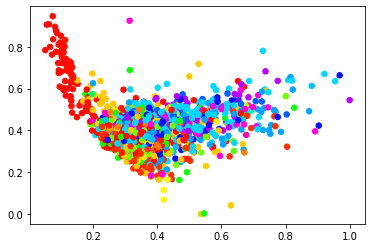

In [ ]:
fig = plt.figure()
#plt.scatter(trans.embedding_[no_drop,0], trans.embedding_[no_drop,1], s=30, c=Ynd[no_drop], cmap='hsv')
#ax.scatter(Xn[dropI,0], Xn[dropI,1], Xn[dropI,2], c=np.zeros(np.shape(dropI)[0]))
plt.scatter(X1[no_drop,1], X1[no_drop,2], s=30, c=Ynd[no_drop], cmap='hsv')

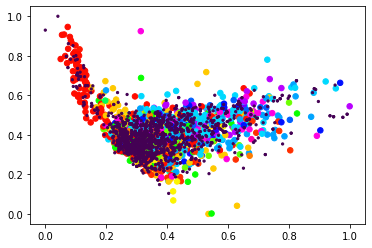

In [ ]:
fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
#plt.scatter(trans.embedding_[:,0], trans.embedding_[:,1], c=Ynd, s=30, cmap='hsv')
#plt.scatter(trans.embedding_[no_drop,0], trans.embedding_[no_drop,1], s=30, c=Ynd[no_drop], cmap='hsv')
#plt.scatter(trans.embedding_[dropI,0], trans.embedding_[dropI,1], s=5, c=np.zeros(np.shape(dropI)[0]))
plt.scatter(X1[no_drop,1], X1[no_drop,2], s=30, c=Ynd[no_drop], cmap='hsv')
plt.scatter(X1[dropI,1], X1[dropI,2], s=5, c=np.zeros(np.shape(dropI)[0]))

In [ ]:
np.shape(dropI), np.shape(Xn), np.shape(Ynd)

((1374,), (2748, 35), (2748,))

In [ ]:
#dropI=np.concatenate((dropI,range(np.shape(X)[0],np.shape(Xn)[0])))
#Thus (Xn,Ynd) is the new data that will be subjected to label propagation
        ################################### so random label removal works!
        #Step 4.2: Apply Label propagation to [X,UX,NUX]
lp_model = LabelSpreading(kernel='rbf',gamma=0.2,alpha=0.1) #high alpha means labels an change till stable
            # Train the model
        #np.savetxt('test.out', Ynd, delimiter=',') 
lp_model.fit(Xn, Ynd)


        #Step 4.3: Predict Model label for the dropped samples
pred = lp_model.transduction_[dropI]
pred=pred.astype(int)
Ynd[dropI]=pred
        #print(np.shape(pred))
        #print('Predictions=',pred)#pred[np.shape(X)[0]:np.shape(X)[0]+np.shape(UX)[0]])
        #print('Groundtruth=',UY)
        ############Predictions to be measured#######################
#predictions=pred[ns:(ns+np.shape(UY)[0])]
        #print(np.shape(predictions)[0])
#pred_labels=np.zeros((np.shape(UY)[0],7))
print(np.shape(Xn),np.shape(Ynd))

(2748, 35) (2748,)


In [ ]:
idx=np.where(Ynd<0)
idx

(array([], dtype=int64),)

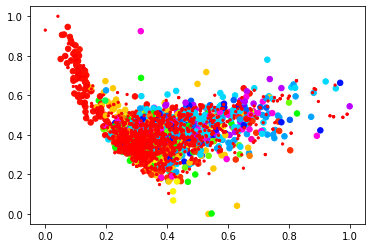

In [ ]:
fig = plt.figure()
plt.scatter(X1[no_drop,1], X1[no_drop,2], s=30, c=Ynd[no_drop], cmap='hsv')
plt.scatter(X1[dropI,1], X1[dropI,2], s=5, c=np.zeros(np.shape(dropI)[0]),cmap='hsv')
#ax = fig.add_subplot(projection='3d')
#plt.scatter(trans.embedding_[:,0], trans.embedding_[:,1], c=Ynd, s=30, cmap='hsv')

In [ ]:
#Step 4.1: LP averaged across all 7 classes (equally likely)


dropP=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]#Fraction of population to be randomly dropped
prec=np.zeros((8,20))
rec=np.zeros((8,20))
fb=np.zeros((8,20))
n=np.shape(X)[0]
########################################################################
#In each loop, randomly drop (dropP) number of samples from X, label propagate on [X, UX, NUX], test on [UX]
for cn in range(20):
    print(cn)
    Xn=np.copy(X1)
    
    for cp,drop in enumerate(dropP):
        Ynd=np.copy(Y)
        #Generate 28 flase labels
        for ni in range(28):
          r_false=randint(0,np.shape(Y)[0]-1)
          Ynd[r_false]=false_label_return(Y[r_false]) #One label flipped randomly
        ns=np.round(drop*n).astype(int)
        #print('num of samples dropped=',ns)
        dropI=np.floor(np.random.rand(ns)*n).astype(int)
        Ynd[dropI]=-1
        #Now combine (Xn, UX1, NUX1)
        Xn=np.concatenate((X1,UX1,NUX1))
        Ynd=np.concatenate((Ynd,YO))
        dropI=np.concatenate((dropI,range(np.shape(X)[0],np.shape(Xn)[0])))
        #Thus (Xn,Ynd) is the new data that will be subjected to label propagation
        ################################### so random label removal works!
        #Step 4.2: Apply Label propagation to [X,UX,NUX]
        lp_model = LabelSpreading(kernel='rbf',gamma=20,alpha=0.1) #high alpha means labels an change till stable
            # Train the model
        #np.savetxt('test.out', Ynd, delimiter=',') 
        lp_model.fit(Xn, Ynd)


        #Step 4.3: Predict Model label for the dropped samples
        pred = lp_model.transduction_[dropI]
        pred=pred.astype(int)
        #print(np.shape(pred))
        #print('Predictions=',pred)#pred[np.shape(X)[0]:np.shape(X)[0]+np.shape(UX)[0]])
        #print('Groundtruth=',UY)
        ############Predictions to be measured#######################
        predictions=pred[ns:(ns+np.shape(UY)[0])]
        #print(np.shape(predictions)[0])
        pred_labels=np.zeros((np.shape(UY)[0],7))
        for i in range(np.shape(predictions)[0]):
          pred_labels[i]=decimal_to_bin(predictions[i])

        #Step 4.4: Compute accuracy, for predictions
        # Modify more multilabel metrics here
        prec[cp][cn], rec[cp][cn], fb[cp][cn]=return_metrics(true_labels,pred_labels)
        dropI=[]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
fb

array([[0.41552311, 0.40866305, 0.4145431 , 0.41184524, 0.41633991,
        0.21743772, 0.41568606, 0.4145431 , 0.4145431 , 0.4145431 ,
        0.4145431 , 0.41462437, 0.41544168, 0.41470567, 0.41552311,
        0.41462437, 0.21711214, 0.41348205, 0.4145431 , 0.41364417],
       [0.21381211, 0.41356309, 0.47448668, 0.41438066, 0.41462437,
        0.41650312, 0.43301737, 0.21595024, 0.45567659, 0.43175196,
        0.41446187, 0.4145431 , 0.41348205, 0.19132092, 0.452718  ,
        0.21404094, 0.18819488, 0.47659471, 0.2149731 , 0.21604262],
       [0.45323856, 0.43739091, 0.45454523, 0.41372528, 0.43150133,
        0.43448788, 0.41364417, 0.41552311, 0.41242141, 0.41380641,
        0.41348205, 0.47888363, 0.41544168, 0.22464682, 0.41356309,
        0.41372528, 0.41356309, 0.41348205, 0.45376198, 0.19247204],
       [0.21274305, 0.43457198, 0.4335202 , 0.2141326 , 0.19111665,
        0.41258309, 0.41544168, 0.45063123, 0.41650312, 0.4747072 ,
        0.41274488, 0.41062307, 0.41062307, 0

In [ ]:
pp=np.mean(prec,axis=1)
rr=np.mean(rec,axis=1)
ff=np.mean(fb,axis=1)
print(np.shape(pp))

(8,)


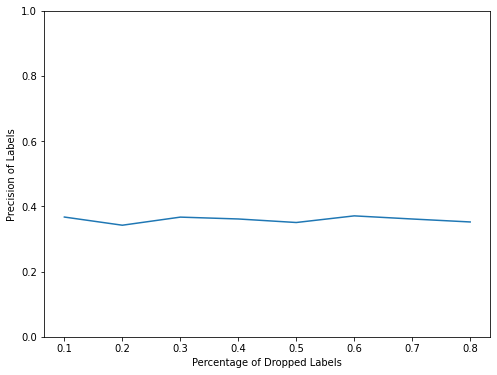

In [ ]:
#Finally generate the plots per cluster
plt.figure(figsize=(8,6))
plt.plot(dropP,pp)
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Precision of Labels')
plt.ylim(0,1)
plt.show()



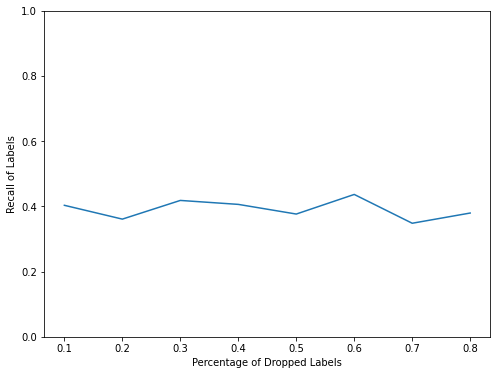

In [ ]:
#Finally generate the plots per cluster
plt.figure(figsize=(8,6))
plt.plot(dropP,rr)
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Recall of Labels')
plt.ylim(0,1)
plt.show()

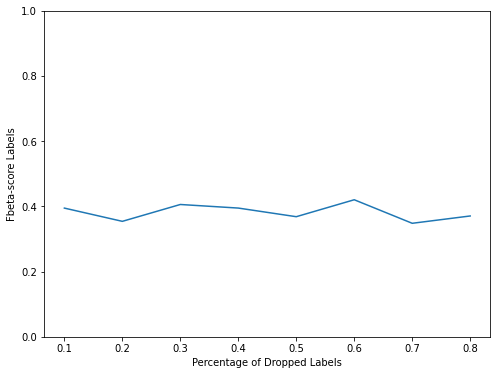

In [ ]:
#Finally generate the plots per cluster
plt.figure(figsize=(8,6))
plt.plot(dropP,ff)
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Fbeta-score Labels')
plt.ylim(0,1)
plt.show()

In [ ]:
def return_per_class_metrics(y_true,y_pred):
  p=np.zeros(7)
  r=np.zeros(7)
  Fbeta=np.zeros(7)
  eps=0.000001
  beta=2*2
  Fbeta=np.zeros(7)
  for i in range(7):
    y_t=y_true[:,i]
    y_p=y_pred[:,i]
    tp = np.sum(y_t * y_p)
    fp = np.sum((y_p - y_t)>0)
    fn = np.sum((y_t - y_p)>0)
    p[i] = tp / (tp + fp + eps)
    r[i] = tp / (tp + fn + eps)
    Fbeta[i]=np.mean((1 + beta) * (p[i] * r[i]) / (beta * p[i] + r[i] + eps))
  return p, r, Fbeta

In [ ]:
#Step 4.1: LP averaged across each class separately

dropP=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]#Fraction of population to be randomly dropped
prec=np.zeros((8,20,7))
rec=np.zeros((8,20,7))
fb=np.zeros((8,20,7))
n=np.shape(X)[0]
########################################################################
#In each loop, randomly drop (dropP) number of samples from X, label propagate on [X, UX, NUX], test on [UX]
for cn in range(20):
    print(cn)
    Xn=np.copy(X1)
    
    for cp,drop in enumerate(dropP):
        Ynd=np.copy(Y)
        #Generate 1% false labels and check
        for ni in range(28):
          r_false=randint(0,np.shape(Y)[0]-1)
          Ynd[r_false]=false_label_return(Y[r_false]) #One label flipped randomly
        ns=np.round(drop*n).astype(int)
        #print('num of samples dropped=',ns)
        dropI=np.floor(np.random.rand(ns)*n).astype(int)
        Ynd[dropI]=-1
        #Now combine (Xn, UX1, NUX1)
        Xn=np.concatenate((X1,UX1,NUX1))
        Ynd=np.concatenate((Ynd,YO))
        dropI=np.concatenate((dropI,range(np.shape(X)[0],np.shape(Xn)[0])))
        #Thus (Xn,Ynd) is the new data that will be subjected to label propagation
        ################################### so random label removal works!
        #Step 4.2: Apply Label propagation to [X,UX,NUX]
        lp_model = LabelSpreading(kernel='rbf',gamma=20,alpha=0.1) #high alpha means labels an change till stable
            # Train the model
        #np.savetxt('test.out', Ynd, delimiter=',') 
        lp_model.fit(Xn, Ynd)


        #Step 4.3: Predict Model label for the dropped samples
        pred = lp_model.transduction_[dropI]
        pred=pred.astype(int)
        #print(np.shape(pred))
        #print('Predictions=',pred)#pred[np.shape(X)[0]:np.shape(X)[0]+np.shape(UX)[0]])
        #print('Groundtruth=',UY)
        ############Predictions to be measured#######################
        predictions=pred[ns:(ns+np.shape(UY)[0])]
        #print(np.shape(predictions)[0])
        pred_labels=np.zeros((np.shape(UY)[0],7))
        for i in range(np.shape(predictions)[0]):
          pred_labels[i]=decimal_to_bin(predictions[i])

        #Step 4.4: Compute accuracy, for predictions
        # Modify more multilabel metrics here
        prec[cp][cn], rec[cp][cn], fb[cp][cn]=return_per_class_metrics(true_labels,pred_labels)
        dropI=[]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
p=np.mean(prec,axis=1)
r=np.mean(rec,axis=1)
f=np.mean(fb,axis=1)
print(np.round(p,2))

[[0.51 0.27 0.28 0.88 0.2  0.12 0.84]
 [0.53 0.27 0.3  0.67 0.23 0.07 0.87]
 [0.53 0.26 0.29 0.63 0.22 0.15 0.87]
 [0.53 0.33 0.29 0.54 0.18 0.1  0.88]
 [0.49 0.3  0.35 0.44 0.17 0.15 0.87]
 [0.48 0.28 0.26 0.56 0.16 0.16 0.82]
 [0.48 0.36 0.31 0.49 0.2  0.22 0.86]
 [0.54 0.38 0.34 0.36 0.15 0.11 0.89]]


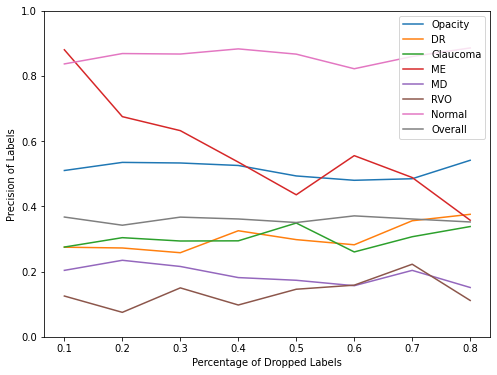

In [ ]:
#Finally generate the plots per cluster
plt.figure(figsize=(8,6))
plt.plot(dropP,p[:,0],label='Opacity')
plt.plot(dropP,p[:,1],label='DR')
plt.plot(dropP,p[:,2],label='Glaucoma')
plt.plot(dropP,p[:,3],label='ME')
plt.plot(dropP,p[:,4],label='MD')
plt.plot(dropP,p[:,5],label='RVO')
plt.plot(dropP,p[:,6],label='Normal')
plt.plot(dropP,pp,label='Overall')
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Precision of Labels')
plt.ylim(0,1)
plt.legend()
plt.show()


(0.0, 1.0)

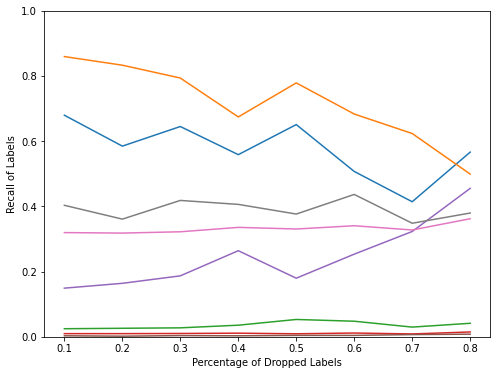

In [ ]:
#Finally generate the plots per cluster
plt.figure(figsize=(8,6))
plt.plot(dropP,r[:,0],label='Opacity')
plt.plot(dropP,r[:,1],label='DR')
plt.plot(dropP,r[:,2],label='Glaucoma')
plt.plot(dropP,r[:,3],label='ME')
plt.plot(dropP,r[:,4],label='MD')
plt.plot(dropP,r[:,5],label='RVO')
plt.plot(dropP,r[:,6],label='Normal')
plt.plot(dropP,rr,label='Overall')
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Recall of Labels')
plt.ylim(0,1)

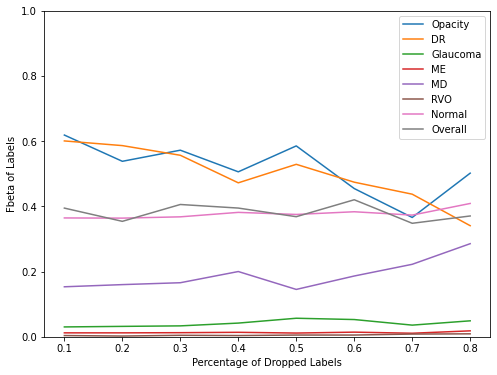

In [ ]:
#Finally generate the plots per cluster
plt.figure(figsize=(8,6))
plt.plot(dropP,f[:,0],label='Opacity')
plt.plot(dropP,f[:,1],label='DR')
plt.plot(dropP,f[:,2],label='Glaucoma')
plt.plot(dropP,f[:,3],label='ME')
plt.plot(dropP,f[:,4],label='MD')
plt.plot(dropP,f[:,5],label='RVO')
plt.plot(dropP,f[:,6],label='Normal')
plt.plot(dropP,ff,label='Overall')
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Fbeta of Labels')
plt.ylim(0,1)
plt.legend()
plt.show()
